In [1]:
# plotting libs
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format 
mpl.rcParams['figure.figsize'] = (9, 6)

# standard
from collections import defaultdict
from datetime import datetime 
from functools import partial
from multiprocessing import Pool, cpu_count
import os
import pickle

# third party
import covidcast
import numpy as np
import pandas as pd
from statsmodels.tsa.tsatools import lagmat

# first party
os.chdir("/Users/mjahja/Delphi/covidcast-nowcast/cases/deconv/code")
from delay import get_international_delays, get_delay_distribution
from conv1d import * 
from weekday import Weekday, dow_adjust_cases

## Delay distributions

Delay distribution found by fitting a gamma distribution to linelist data.

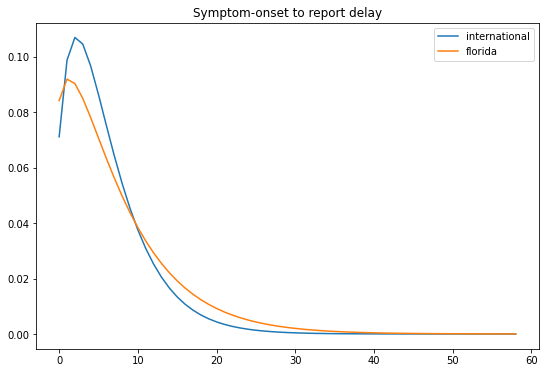

In [2]:
international_delays = get_international_delays(download=True)
delay_dist = get_delay_distribution(international_delays)
intl_delay_dist = get_delay_distribution(international_delays)

# https://www.arcgis.com/home/item.html?id=37abda537d17458bae6677b8ab75fcb9
florida_df = pd.read_csv("~/Downloads/Case_Data (1).csv", parse_dates=["Case_", "EventDate", "ChartDate"])
florida_delays = (florida_df.ChartDate - florida_df.EventDate).dt.days
florida_delays = florida_delays[florida_delays.gt(0) & florida_delays.lt(60)]
fl_delay_dist = get_delay_distribution(florida_delays)

plt.plot(intl_delay_dist, label="international")
plt.plot(fl_delay_dist, label="florida")
plt.title("Symptom-onset to report delay")
plt.legend()
plt.show()

Pull case data.

In [3]:
start_date = datetime(2020, 3, 15)
end_date = datetime(2020, 9, 15)

cases_df = covidcast.signal(
        'indicator-combination',
        'confirmed_7dav_incidence_num',
        start_date, end_date,
        geo_type='county')

cumulative_cases_df = covidcast.signal(
        'indicator-combination',
        'confirmed_7dav_cumulative_num',
        end_date, end_date,
        geo_type='county')

thresh_geos = cumulative_cases_df[cumulative_cases_df.value > 500].geo_value 

In [4]:
# get all florida fips codes
geo_map = pd.read_csv(
            "~/Delphi/covid-19/geographical_scope/02_20_uszips.csv",
            usecols=["fips", "state_id", "population"],
            dtype={"state_id": str},
            converters={"fips": lambda x: str(x).zfill(5)},
        )

florida_geo = geo_map[geo_map.state_id.eq("FL")]
florida_population = florida_geo.groupby("fips").population.sum().reset_index()
florida_fips = florida_geo.fips.unique()

In [5]:
cases_df = cases_df.set_index(["geo_value"])
geos = cases_df.index.unique()
geos = geos[geos.isin(florida_fips)] # only keep florida geos
geos = geos[geos.isin(thresh_geos)]  # counties with >500 cumulative cases

### Models

In [6]:
def regress(X, y):
    """Simple OLS, adds intercept. Returns coefs and fitted vals."""
    X = np.hstack((np.ones((y.size, 1)), X.reshape(-1, 1)))
    beta = np.linalg.inv(X.T @ X + 1e-4 * np.eye(X.shape[1])) @ X.T @ y 
    return beta, (X @ beta)

def strawman(x_tilde, delay):
    """
    The prediction x_hat at time t is x_tilde (infections)
    at time t-1:
    
      x_hat{t} = x_tilde{t-1}
    
    Returns a tuple of the corresponding time indices to the
    convolution y_hat = delay(*)x_hat.
    
    """
    n = x_tilde.shape[0]
    x_hat = lagmat(x_tilde, 1).reshape(-1,)
    x_pred = x_tilde[-1] # prediction for next time point
    x_hat = np.append(x_hat, x_pred)
    
    y_hat = Conv1D.freq_conv(x_hat, delay)[:n]
    return (np.arange(1, n+1), y_hat)

def ar(x_tilde, delay, p, lam=1):
    """
    Fit an AR(p) model on x_tilde. 
    
    Returns a tuple of the corresponding time indices to the
    convolution y_hat = delay(*)x_hat.
    
    """
    n = x_tilde.shape[0]
    
    # lag matrix
    Z = np.hstack((np.ones((n, 1)), lagmat(x_tilde, maxlag=p)))[p:]
    Z1 = np.concatenate([[1], np.flip(x_tilde[-p:])])
    beta = np.linalg.solve(Z.T @ Z + lam*np.eye(p+1), Z.T @ x_tilde[p:])
    x_hat = Z @ beta
    x_pred = beta.T @ Z1 # prediction for next time point
    x_hat = np.append(x_hat, x_pred)
    
    y_hat = Conv1D.freq_conv(x_hat, delay)[:(Z.shape[0]+1)]
    return (np.arange(p, n+1), y_hat)


def sf(x_tilde, train_signals, test_signals, delay, alpha=1):
    """
    Sensor fusion. 
    
    
    - [TODO] Fit on more than one location. Currently, H=1.
    - [TODO] This does not properly fit sensors sequentially.
    
    Args:
        x_tilde: infections vector
        train_signals: raw signal matrix to become sensors
        test_signals: raw signal vector at nowcasting time
        delay: reporting delay vector
        alpha: l2 regularization parameter
        
    """
    n, p = train_signals.shape
    p += 1 # add intercept
    H = np.ones((p, 1))

    # fit sensors
    Z = np.full((n, p), np.nan)
    z1 = np.full((p,), np.nan)
    for j in range(p):
        if j < (p-1):
            beta, fitted_vals = regress(train_signals[:, j], x_tilde)
            Z[:,j] = fitted_vals
            z1[j] = beta.T @ np.array([1, test_signals[j]])
        else:
            Z[:, j] = np.ones(n)
            z1[j] = 1


    X = x_tilde.reshape(-1, 1)
    G = Z - X @ H.T
    #G = G - G.mean(axis=0)
    cov_G = G.T @ G / n
    Ri = np.linalg.inv(alpha * cov_G + (1 - alpha) * np.eye(p))
    beta = np.linalg.inv(H.T @ Ri @ H) @ H.T @ Ri
    x_hat = Z @ beta.T
    x_pred = beta @ z1 # prediction for next time point
    x_hat = np.append(x_hat, x_pred)
    
    y_hat = Conv1D.freq_conv(x_hat, delay)[:(n+1)]
    return (None, y_hat)

## Nowcasting Miami-Dade (12086)

/usr/local/lib/python3.7/site-packages/covidcast/covidcast.py:321: UserWarning: Problem obtaining data on 20200315: no results
  message=day_data["message"]))
/usr/local/lib/python3.7/site-packages/covidcast/covidcast.py:321: UserWarning: Problem obtaining data on 20200316: no results
  message=day_data["message"]))
/usr/local/lib/python3.7/site-packages/covidcast/covidcast.py:321: UserWarning: Problem obtaining data on 20200317: no results
  message=day_data["message"]))
/usr/local/lib/python3.7/site-packages/covidcast/covidcast.py:321: UserWarning: Problem obtaining data on 20200318: no results
  message=day_data["message"]))
/usr/local/lib/python3.7/site-packages/covidcast/covidcast.py:321: UserWarning: Problem obtaining data on 20200319: no results
  message=day_data["message"]))
/usr/local/lib/python3.7/site-packages/covidcast/covidcast.py:321: UserWarning: Problem obtaining data on 20200320: no results
  message=day_data["message"]))
/usr/local/lib/python3.7/site-packages/covidca

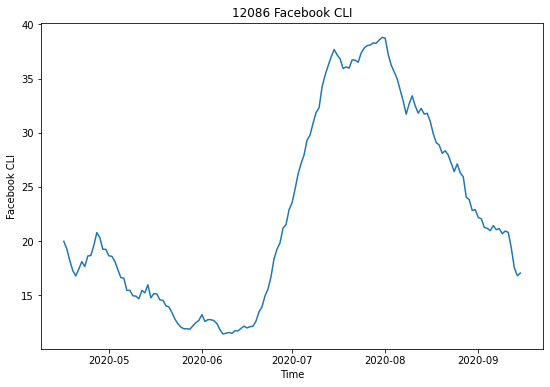

In [7]:
geo = "12086"
cases = cases_df.loc[geo].sort_values(by='time_value')
n = cases.value.shape[0]

fb_df = covidcast.signal(
        'fb-survey', 
        'smoothed_hh_cmnty_cli',
        start_date, end_date,
        geo_type='county',
        geo_values=geo)

fb = fb_df[['time_value', 'value']]
plt.plot(fb.time_value, fb.value)
plt.xlabel("Time")
plt.ylabel("Facebook CLI")
plt.title(f"{geo} Facebook CLI")
plt.show()

### Deconvolution Approaches

(1) Direct deconvolution in the frequency domain.

(2) Solve

\begin{equation}
\hat{x}=\underset{x}{\operatorname{argmin}} \frac{1}{2}\|y-W x\|_{2}^{2}+\lambda\left\|D^{(k+1)} x\right\|_{1}
\end{equation}

where $D^{(k+1)}$ is the discrete difference operator, and $W$ the convolution matrix.

(3) Solve

\begin{equation}
\hat{x}=\underset{x}{\operatorname{argmin}} \frac{1}{2}\|W^{-1}y-x\|_{2}^{2}+\lambda\left\|D^{(k+1)} x\right\|_{1}.
\end{equation}

where $W^{-1}$ is the deconvolution matrix.

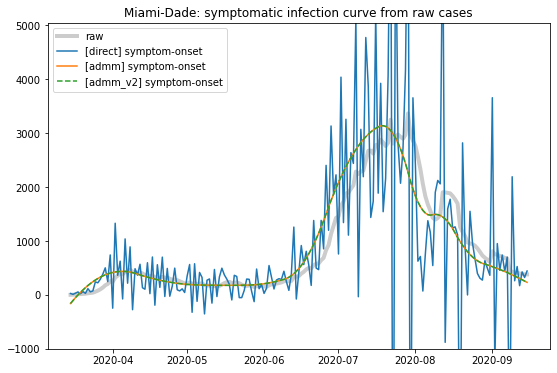

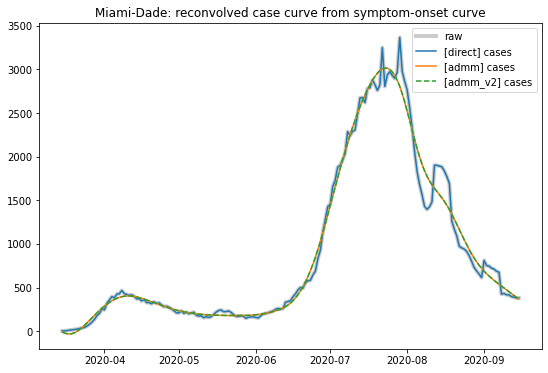

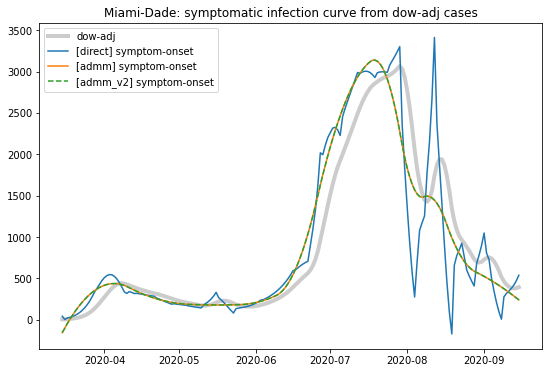

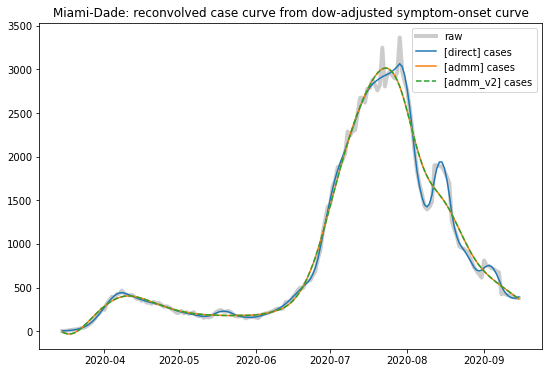

In [8]:
dates = cases.time_value

direct = Conv1D.freq_deconv(cases.value, delay_dist)[:n]
admm_v1 = admm_deconvolution(cases.value, delay_dist, 
                             lam=20, rho=20, n_iters=500, k=2)
admm_v2 = admm_deconvolution_v2(cases.value, delay_dist,
                                lam=200, rho=200, n_iters=500, k=2)

plt.plot(dates, cases.value, label="raw", color="black", linewidth=4, alpha=0.2)
plt.plot(dates, direct, label="[direct] symptom-onset")
plt.plot(dates, admm_v1, label="[admm] symptom-onset")
plt.plot(dates, admm_v1, label="[admm_v2] symptom-onset", linestyle="--")
plt.title("Miami-Dade: symptomatic infection curve from raw cases")
plt.ylim(-1000, 1.5 * max(cases.value))
plt.legend()
plt.show()

plt.plot(dates, cases.value, label="raw", color="black", linewidth=4, alpha=0.2)
plt.plot(dates, Conv1D.freq_conv(direct, delay_dist)[:n], label="[direct] cases")
plt.plot(dates, Conv1D.freq_conv(admm_v1, delay_dist)[:n], label="[admm] cases")
plt.plot(dates, Conv1D.freq_conv(admm_v1, delay_dist)[:n], 
         label="[admm_v2] cases", linestyle="--")
plt.title("Miami-Dade: reconvolved case curve from symptom-onset curve")
plt.legend()
plt.show()


adj_cases = dow_adjust_cases(cases, lam=10)
direct = Conv1D.freq_deconv(adj_cases, delay_dist)[:n]
admm_v1 = admm_deconvolution(adj_cases, delay_dist, lam=20, rho=20, n_iters=500, k=2)
admm_v2 = admm_deconvolution_v2(adj_cases, delay_dist, lam=200, rho=200, n_iters=500, k=2)
plt.plot(dates, adj_cases, label="dow-adj", color="black", linewidth=4, alpha=0.2)
plt.plot(dates, direct, label="[direct] symptom-onset")
plt.plot(dates, admm_v1, label="[admm] symptom-onset")
plt.plot(dates, admm_v1, label="[admm_v2] symptom-onset", linestyle="--")
plt.title("Miami-Dade: symptomatic infection curve from dow-adj cases")
plt.legend()
plt.show()

plt.plot(dates, cases.value, label="raw", color="black", linewidth=4, alpha=0.2)
plt.plot(dates, Conv1D.freq_conv(direct, delay_dist)[:n], label="[direct] cases")
plt.plot(dates, Conv1D.freq_conv(admm_v1, delay_dist)[:n], label="[admm] cases")
plt.plot(dates, Conv1D.freq_conv(admm_v1, delay_dist)[:n],
         label="[admm_v2] cases", linestyle="--")
plt.title("Miami-Dade: reconvolved case curve from dow-adjusted symptom-onset curve")
plt.legend()
plt.show()

### Miami-Dade linelist

Comparison with International, Florida, and Miami-Dade linelists.

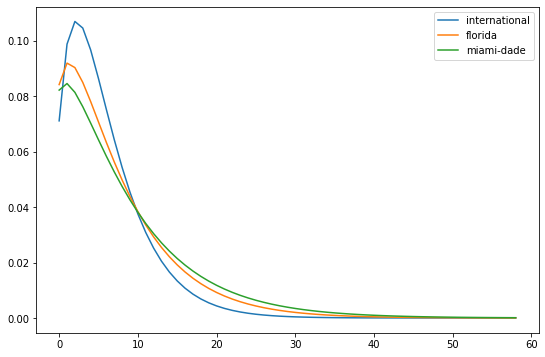

In [9]:
miami_dade = florida_df[florida_df.County.eq("Dade")]
miami_dade = miami_dade[miami_dade.ChartDate >= datetime(2020, 6, 1)]
miami_dade_delays = (miami_dade.ChartDate - miami_dade.EventDate).dt.days
miami_dade_delays = miami_dade_delays[miami_dade_delays.gt(0) & miami_dade_delays.lt(60)]
miami_dade_delay_dist = get_delay_distribution(miami_dade_delays)

plt.plot(intl_delay_dist, label="international")
plt.plot(fl_delay_dist, label="florida")
plt.plot(miami_dade_delay_dist, label="miami-dade")
plt.legend()
plt.show()

## Nowcasting

We will compare (semi)retrospective performance of the strawman, AR(7), and SF method. 

All three methods will recieve identical symptom onset curves. The symptom onset curve is estimated using method (3) of deconvolution (via ADMM), with the three different delay distributions.

Finished 100/185
Finished 120/185
Finished 140/185
Finished 160/185
Finished 180/185


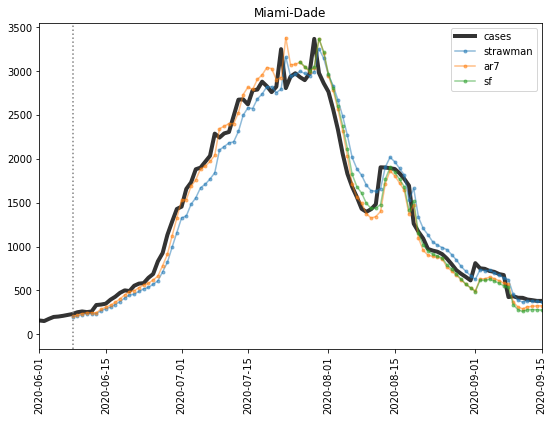

In [10]:
intl_preds = defaultdict(lambda: {'time': [],'pred': []})
fl_preds = defaultdict(lambda: {'time': [],'pred': []})
miami_dade_preds = defaultdict(lambda: {'time': [],'pred': []})

t1 = n
t0 = t1-100
for t in range(t0, t1):
    train_time = cases.time_value[:t]
    test_time = cases.time_value.values[t]
    train_cases = cases[cases.time_value.isin(train_time)]
    n_train_obs = train_cases.shape[0]
    train_cases = dow_adjust_cases(train_cases, lam=10)

    for delay_dist, preds in zip([intl_delay_dist, fl_delay_dist, miami_dade_delay_dist],
                                 [intl_preds, fl_preds, miami_dade_preds]):
        # get infection curve
        ## commented out - this does CV and is necessary for good performance but slow
        ## after observing the output, we rerun with a fixed lambda for speed
        # sub_infections = infection_curve::get_infection_curve(train_cases, delay_dist)
        sub_infections = np.clip(admm_deconvolution_v2(
            train_cases, delay_dist, 3000, 3000, n_iters=500, k=2), 0, np.inf)

        # strawman
        strawman0 = strawman(sub_infections, delay_dist)
        preds["strawman"]["pred"].append(strawman0[1][-1])
        preds["strawman"]["time"].append(test_time)

        # ar7 model
        n_lags = 7
        ar0 = ar(sub_infections, delay_dist, n_lags)
        preds["ar7"]["pred"].append(ar0[1][-1])
        preds["ar7"]["time"].append(test_time)
        
        # sf model (fb_survey, ar7, strawman)
        train_fb = fb[fb.time_value.isin(train_time)]
        test_fb = fb[fb.time_value.eq(test_time)]
        train_ar = pd.DataFrame({'time_value': train_time[(n_lags-1):], 
                                 'ar': ar0[1]})
        test_ar = ar0[1][-1]
        
        train_straw = pd.DataFrame({'time_value': train_time, 
                                 'strawman': strawman0[1]})
        test_straw = strawman0[1][-1]
        if test_fb.size > 0:
            sf_df = (pd.DataFrame({'infections': sub_infections, 
                                   'time_value': train_time})
                     .merge(train_fb, how='left', on='time_value')
                     .merge(train_ar, how='left', on='time_value')
                     .merge(train_straw, how='left', on='time_value'))
            valid_ind = sf_df.notna().all(axis=1)
            sf_df.drop(columns=['time_value', 'infections'], inplace=True)

            if valid_ind.sum() > 100:
                train_infections = sub_infections[valid_ind]
                train_signals = sf_df.to_numpy()[valid_ind, :]
                test_signals = np.array((
                   test_fb.value.values[0], 
                    test_ar,
                    test_straw)).flatten()

                sf0 = sf(train_infections, train_signals, 
                         test_signals, delay_dist, 0.5)
                preds["sf"]["pred"].append(sf0[1][-1])
                preds["sf"]["time"].append(test_time)

    if t % 20 == 0: print(f"Finished {t}/{t1}")
                 

plt.title("Miami-Dade")
plt.plot(cases.time_value, cases.value, label="cases", color="black", linewidth=4, alpha=0.8)
for k in preds.keys():
    plt.plot(preds[k]['time'], preds[k]["pred"], label=k, marker=".", alpha=0.5)
plt.axvline(x=cases.time_value.values[t0], color="gray", linestyle=":")
plt.xlim(datetime(2020, 6, 1), end_date)
plt.legend()
plt.xticks(rotation=90)
plt.show()

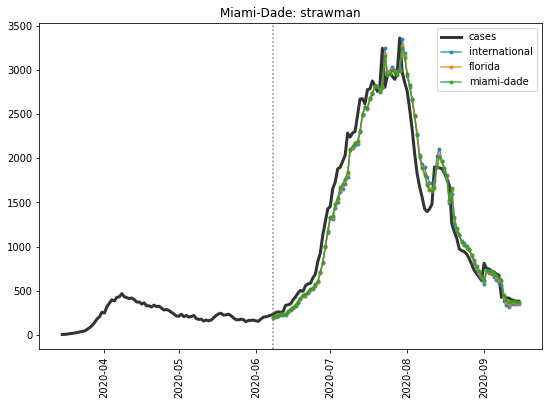

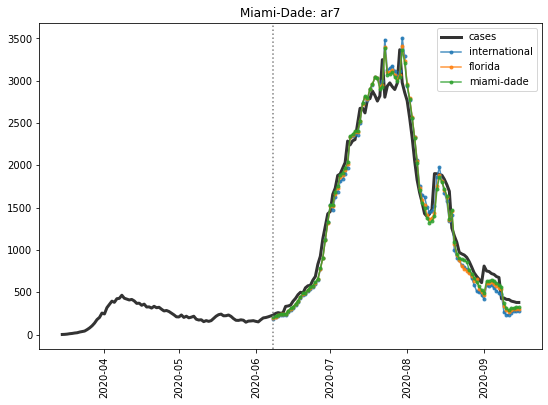

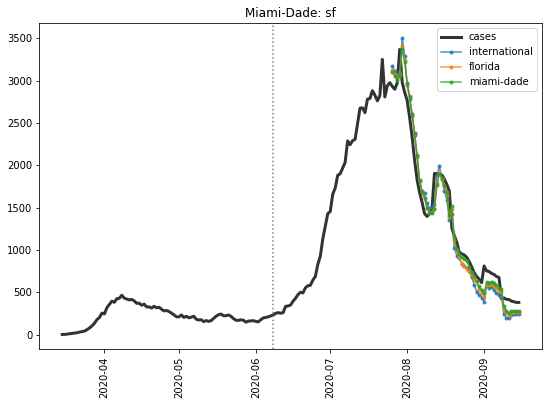

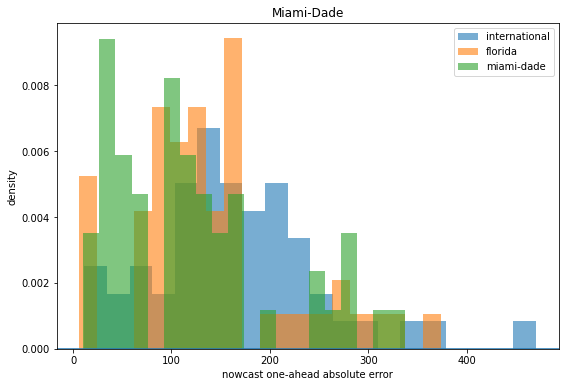

In [11]:
for method in ["strawman", "ar7", "sf"]:
    plt.plot(cases.time_value, cases.value, label="cases", color="black", linewidth=3, alpha=0.8)
    for name, preds in zip(["international", "florida", "miami-dade"],
                           [intl_preds, fl_preds, miami_dade_preds]):
        plt.plot(preds[method]['time'],
                 preds[method]["pred"],
                 label=name, marker=".", alpha=0.8)
    plt.axvline(x=cases.time_value.values[t0], color="gray", linestyle=":")
    plt.legend()
    plt.title(f"Miami-Dade: {method}")
    plt.xticks(rotation=90)
    plt.show()

cases_adj = dow_adjust_cases(cases, lam=10)
cases["adj_value"] = cases_adj
for name, preds in zip(["international", "florida", "miami-dade"],
                       [intl_preds, fl_preds, miami_dade_preds]):
    preds_df = pd.DataFrame({"time_value": preds[method]['time'], 'preds': preds[method]["pred"]})
    tmp = preds_df.merge(cases, how="left", on="time_value")
    
    plt.hist(np.abs(tmp.adj_value - tmp.preds), 
             label=name, alpha=0.6, density=True, bins=20)

plt.legend()
plt.title(f"Miami-Dade")
plt.xlabel("nowcast one-ahead absolute error")
plt.ylabel("density")
plt.axhline(0)
plt.show()

In [12]:
## parallelized version

# def batch_nowcast(geo, y, delay, ts, t0, t1, model):
#     """
#     Make nowcasts over time range [t0, t1).
    
#     Args:
#         y: ordered array of cases
#         delay: ordered array of delay probabilities
#         ts: ordered array of complete timepoints corresponding to y
#         t0: index of starting timepoint for prediction
#         t1: index of ending timepoint for prediction
#         model: fitting function
        
#     """
#     #infection_curve = InfectionCurve(delay).get_infection_curve
#     res = {"pred": [], "time": []}
#     for t in range(t0, t1):
#         train_time = ts[:t]
#         test_time = ts[t]
#         train_y = y[:t]
        
#         # get infection curve (x_tilde)
#         x_tilde = np.clip(admm_deconvolution(train_y, delay, 50, 50, n_iters=300, k=2), 0, np.inf)
# #         plt.plot(train_y)
# #         plt.plot(x_tilde)
# #         plt.show()
#         #x_tilde = infection_curve(train_y)
        
#         # fit model
#         _, out_y = model(x_tilde, delay)
#         res["pred"].append(out_y[-1])
#         res["time"].append(test_time)
        
#     print(f"{geo}, {res['pred'][-1]:.3f}")
#     return {geo: res}

# ar7 = partial(ar, p=7)
# for method, method_str in zip([strawman, ar7], ["strawman", "ar7"]):
#     n_cpu = min(5, cpu_count())
#     pool = Pool(n_cpu)
#     pool_results = []

#     for geo in sample_geos:
#         cases = cases_df.loc[geo].sort_values(by='time_value')
#         dates = cases.time_value.values
#         cases = dow_adjust(cases)
#         n = cases.shape[0]
#         pool_results.append(
#             pool.apply_async(batch_nowcast, 
#                              args=(geo, 
#                                    cases, 
#                                    delay_dist,
#                                    dates,
#                                    n-50, n, 
#                                    method,)
#                             )
#         )

#     pool_results = [proc.get() for proc in pool_results]
#     pickle.dump(pool_results, open(f"{method_str}_fl.p", "wb"))
#     print(f"finished {method_str}")

# # load data
# def unpack(fn):
#     fp = pickle.load(open(fn, "rb"))
#     out = {}
#     for arr in fp:
#         out[list(arr.keys())[0]] = arr[list(arr.keys())[0]]
#     return out

# strawman_res = unpack("strawman_fl.p")
# ar7_res = unpack("ar7_fl.p")

# out_pdf = f"comp_fl.pdf"
# pdf_pages = PdfPages(out_pdf)
# n_plot = len(pool_results)
# n_row = 4
# n_col = 4
# n_plots_per_page = n_row*n_col
# fig, axs = None, None
# j = 0
# for i, geo in enumerate(sample_geos):
#     cases = cases_df.loc[geo].sort_values(by='time_value')
#     if i % n_plots_per_page == 0:
#         fig, axs = plt.subplots(n_row, n_col, figsize=(12, 12), sharex=True)
#         axs = axs.ravel()
#         j = 0
        
#     axs[j].plot(cases.time_value.values, cases.value.values, 
#                 color="black", label="cases", linewidth=3, alpha=0.8)
#     axs[j].plot(strawman_res[geo]["time"], strawman_res[geo]["pred"], label="strawman", marker=".")
#     axs[j].plot(ar7_res[geo]["time"], ar7_res[geo]["pred"], label="ar7", marker=".")
#     axs[j].legend(fontsize=8)
#     axs[j].set_title(geo)
#     axs[j].tick_params(axis='both', which='major', labelsize=5, labelrotation=90)

#     # close the page if needed
#     if (i + 1) % n_plots_per_page == 0 or (i + 1) == n_plot:
#         plt.tight_layout()
#         pdf_pages.savefig(fig)
#         plt.close()
#     j += 1
# pdf_pages.close()
# print(f"Saved to {out_pdf}") 
    
# plt.plot(cases.time_value, cases.value, label="cases", color="black", linewidth=4, alpha=0.8)
# for k in preds.keys():
#     plt.plot(preds[k]['time'], preds[k]["pred"], label=k, marker=".", alpha=0.5)
# plt.axvline(x=cases.time_value.values[t0], color="gray", linestyle=":")
# plt.legend()
# plt.xticks(rotation=90)
# plt.show()